In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.signal import resample, find_peaks, peak_prominences
from signal_pross import (
    normalize_signal,
    detrend_w_poly,
    normalize_amplitude_to_1,
    n_moving_avg,
    min_max_scale
)
from truth import IeeeGroundTruth
from wavelet import apply_wavelet

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [2]:
truths = []
for subject in range(1, 8):

    truth = IeeeGroundTruth(subject, 1, directory = 'channel_data3')  # basic method
    truth.align_rgb_bvp()
    truth.fill_nans()
    truth.process_rgb()
    truth.process_bvp()

    truths.append(truth)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


class RppgMl:
    
    def __init__(self, data, label_col = 'bvp', subject_col = 'subject', test_size = 0.2, random_state = 0):

        self.data = data
        self.label_col = label_col
        self.subject_col = subject_col
        self.test_size = test_size
        self.random_state = random_state

        self.X = self.data.drop(columns = [self.label_col, self.subject_col])
        self.y = self.data[self.label_col]
        
        (
            self.X_train, self.X_test,
            self.y_train, self.y_test
        ) = train_test_split(self.X, self.y, test_size = self.test_size, random_state = self.random_state)

        self.X_train = self.X_train.to_numpy()
        self.X_test = self.X_test.to_numpy()
        self.y_train = self.y_train.to_numpy()
        self.y_test = self.y_test.to_numpy()
    
    def train_skl(self, model):
        self.skl_model = model(random_state = self.random_state)
        self.skl_model.fit(self.X_train, self.y_train)

    def predict_skl(self, x):
        return self.skl_model.predict(x)
    
    def eval_skl(self):
        return mean_squared_error(self.y_test, self.predict_skl(self.X_test))
    
    def feature_importances(self):
        importances = self.skl_model.feature_importances_
        feature_names = self.X.columns
        result = pd.DataFrame({'feature': feature_names, 'importance': importances})
        result = result.sort_values(by='importance', ascending=False)
        return result

In [4]:
test_subject = 6

data_arr = []
for i in range(len(truths)):
    if i == (test_subject - 1):
        continue
    truth = truths[i]
    data = truth.prepare_data_for_ml()
    data = data.iloc[1000: 15000, :]
    data['subject'] = i + 1
    data_arr.append(data)

data = pd.concat(data_arr)
display(data.head())

    
ml = RppgMl(data.copy())
ml.train_skl(RandomForestRegressor)
err = ml.eval_skl()
feature_importances = ml.feature_importances()

print(f'\n\nError: {err}')
print(f'Feature importances: {feature_importances}')
print()

,r,g,b,bvp,subject
1000,24.836498,16.673300,14.442700,0.039463,1
1001,24.877025,16.654101,14.478025,0.037491,1
1002,24.883844,16.651262,14.469329,0.034246,1
1003,24.863240,16.642592,14.413129,0.029799,1
1004,24.837014,16.623690,14.344018,0.024385,1




Error: 0.0019781506949514372
Feature importances:   feature  importance
0       r    0.366258
2       b    0.330116
1       g    0.303626



In [5]:
0.0019781506949514372

0.0019781506949514372

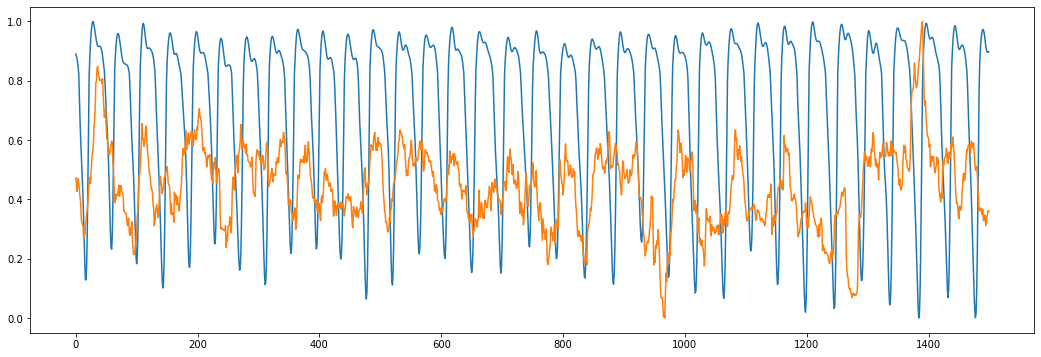

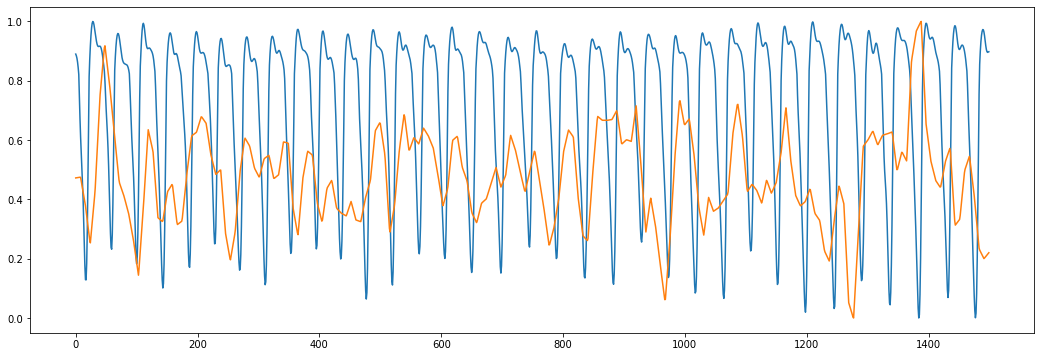

In [6]:
model = ml
smoothing_window = 20
ground_truth_smoothing_window = 20

beg = 3000
end = 4500

test_X = truths[test_subject - 1].prepare_data_for_ml().drop(columns = ['bvp']).to_numpy()
test_y = truths[test_subject - 1].prepare_data_for_ml().bvp.to_numpy()

pred = model.predict_skl(test_X)
pred = n_moving_avg(pred, smoothing_window)
pred = resample(pred, len(test_y))

signal = pred[beg: end]
targets = test_y[beg: end]
signal = min_max_scale(signal)
targets = min_max_scale(targets)

plt.plot(targets)
plt.plot(signal)
plt.show()

signal = apply_wavelet(signal, 'db2', 3)
signal = detrend_w_poly(signal)
signal = min_max_scale(signal)

plt.plot(targets)
plt.plot(signal)

In [7]:
def get_peaks_v2(signal: np.ndarray, fr: int, max_freq: float, peak_height: float,
    prominence: float = 0, with_valleys: bool = False,
    with_min_dist: bool = True):
    
    # skip any None values at the beggining of the signal
    first_index = None
    for i in range(len(signal)):
        if signal[i] is not None:
            first_index = i
            break
    signal = signal[first_index: ]

    def _peak_getter(sig):
        min_dist = fr // max_freq if with_min_dist else 1
        
        peaks, _ = find_peaks(sig, height = peak_height, prominence = prominence, distance = min_dist)
        
        prominences = {p + first_index: prom for p, prom in zip(peaks, peak_prominences(sig, peaks)[0])}
        return [p + first_index for p in peaks], prominences

    peaks, peak_proms = _peak_getter(signal)
    if with_valleys:
        valleys, valley_prominences = _peak_getter(-signal)

        peaks = sorted(list(set(peaks + valleys)))
        peak_proms = {**peak_proms, **valley_prominences}
        return peaks, peak_proms

    return peaks, peak_proms

Number of true peaks: 33
Number of predicted peaks: 25


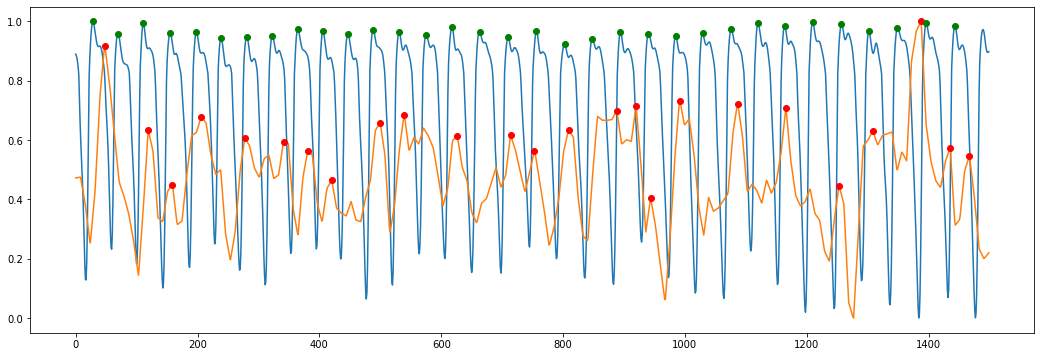

In [8]:
peaks, peak_proms = get_peaks_v2(
    signal,
    64,
    3.0,
    -1,
    prominence = 0.1,
    with_min_dist = True,
    with_valleys = False
)
true_peaks, _ = get_peaks_v2(
    targets,
    64,
    3.0,
    -1,
    prominence = 0.2,
    with_min_dist = True,
    with_valleys = False
)

plt.plot(targets)
plt.plot(signal)
plt.plot(peaks, signal[peaks], 'ro')
plt.plot(true_peaks, targets[true_peaks], 'go')

print(f'Number of true peaks: {len(true_peaks)}')
print(f'Number of predicted peaks: {len(peaks)}')